# Set-up

In [1]:
fig <- function(w=NULL, h=NULL){options(repr.plot.width = w, repr.plot.height = h)}

library(dplyr)
library(DESeq2)
library(Seurat)
library(ggplot2)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching 

# Data

### Macaque data

In [2]:
# Raw exp
# seu <- readRDS('~/projects_ro/codebases/MacaqueDev/Processed/DATA/All.MNN.v1.org.fct.rds')
seu <- readRDS('~/codebases/MacBrainDev/data/All.MNN.v1.org.fct.rds')

In [3]:
Idents(seu) <- 'subtype'

### DV bias

In [4]:
load('./raw/TelleyDeconDV/DorsalVentralDeSeq2.rda', verbose=T)
r8

Loading objects:
  r8
  r17
  r30


log2 fold change (MLE): group dorsal_8 vs ventral_8 
Wald test p-value: group dorsal_8 vs ventral_8 
DataFrame with 23368 rows and 6 columns
             baseMean log2FoldChange     lfcSE       stat     pvalue      padj
            <numeric>      <numeric> <numeric>  <numeric>  <numeric> <numeric>
1/2-SBSRNA4 25.432990     -0.1107542  0.380075  -0.291401   0.770744  0.977093
A1BG        85.697743     -0.0639413  0.377484  -0.169388   0.865491  0.989959
A1BG-AS1    82.613913      0.2169445  0.425004   0.510453   0.609734  0.956519
A1CF         0.563897      0.4269121  3.617313   0.118019   0.906052        NA
A2LD1       93.305308      0.0906135  0.358900   0.252475   0.800674  0.979480
...               ...            ...       ...        ...        ...       ...
ZYG11B       2747.213     -0.1466625  0.168663 -0.8695616 0.38454003  0.889557
ZYX           917.679      0.8941399  0.334107  2.6762075 0.00744605  0.154503
ZZEF1        1208.910      0.1879862  0.155300  1.2104746 0.22609682 

In [5]:
dv.bias <- do.call(what='rbind', list(
    data.frame(r8, DIV='D8',
               gene=rownames(r8)),
    data.frame(r17, DIV='D17',
               gene=rownames(r17)),
    data.frame(r30, DIV='D30',
               gene=rownames(r30)))) %>%
    mutate(DV = sign(log2FoldChange)) %>% 
    arrange(log2FoldChange) %>%
    mutate(DV = factor(ifelse(padj < 0.05, DV, 0),
                       levels=c(-1,0,1),
                       labels=c('Ventral', 'None', 'Dorsal')),
           DIV = factor(DIV, c('D8', 'D17', 'D30'))
)
length(unique(dv.bias$gene))
dim(dv.bias)
head(dv.bias)


[1] 23368

[1] 70104     9

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DIV,gene,DV
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>
WASH5P2,101.8520,-16.494851,2.517314,-6.552560,5.655907e-11,3.074856e-09,D30,WASH5P,Ventral
LHX82,556.7072,-8.686007,1.559420,-5.570023,2.547051e-08,8.244862e-07,D30,LHX8,Ventral
ZNF300P12,34.2653,-8.659899,2.605086,-3.324228,8.866371e-04,6.898687e-03,D30,ZNF300P1,Ventral
ZNF300P11,34.2653,-7.766444,2.604916,-2.981456,2.868809e-03,4.325382e-02,D17,ZNF300P1,Ventral
NKX2-12,934.9149,-7.478520,1.214112,-6.159662,7.290026e-10,3.228549e-08,D30,NKX2-1,Ventral
SFTA32,190.4017,-7.373883,1.253484,-5.882709,4.036057e-09,1.552372e-07,D30,SFTA3,Ventral


In [6]:
# dv.colors <- c("Dorsal" = "goldenrod2", "Ventral" = "forestgreen", 'None'='white')
# nicola pointed out that the colors are the other way rounf in the rest of the figures
dv.colors <- c("Dorsal" = "forestgreen", "Ventral" = "goldenrod2", 'None'='white')

### Diseases

In [7]:
diseases.df <- read.csv('data/gene_disorder_associations.intersectionExpData.csv', row.names=1)
diseases.df <- diseases.df[rowSums(diseases.df) > 0,]
dim(diseases.df)
head(diseases.df)

[1] 2024   19

,Microcephaly,Hydrocephaly,RareMCD,MDD_2018,Polymicrogyria,SCZ_2020,AN_2019,NEUROT_2018,PD_2014,AD_2019,Lissencephaly,BD_2019,DevDyslexia,Heterotopia,ADHD_2019,DD,FCDandmTOR,Cobblestone,ASD
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SLC25A27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
EXOC6B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
RBM4B,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
NACC1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TSPAN7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MUC12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
sum(rownames(diseases.df)%in% unique(dv.bias$gene))

[1] 2024

### Macaque PC markers

In [9]:
# pc.markers <- data.table::fread("~/projects_ro/codebases/MacaqueDev/Processed/DATA/Disease_expression_data.Markers.PCs_1.csv") %>% mutate(V1=NULL)  
# pc.markers <- data.table::fread("~/codebases/MacaqueDev2023/data/Disease_expression_data.Markers.PCs_1.csv") %>% mutate(V1=NULL)  
pc.markers <- data.table::fread("~/codebases/MacBrainDev/data/Disease_expression_data.Markers.PCs_1.csv") %>% mutate(V1=NULL)  
head(pc.markers)

pc.subtypes <- unique(pc.markers$cluster)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,1.536375,0.686,0.181,0,PC FGF17,ZIC4
0,1.440335,0.795,0.230,0,PC FGF17,DLK1
0,1.345359,0.181,0.009,0,PC FGF17,FGF8
0,1.312989,0.257,0.007,0,PC FGF17,FGF18
0,1.256460,0.432,0.058,0,PC FGF17,DUSP6
0,1.250733,0.381,0.038,0,PC FGF17,SP8


### Some checks

In [10]:
dv.bias %>% subset(DV!='None') %>% with(., {split(gene, DV)}) -> dv.list
dv.df <- data.frame(lapply(dv.list, function(x){unique(dv.list %>%unlist()) %in% x}), row.names=unique(dv.list %>%unlist()))
dv.df %>%apply(1, function(x){paste(sort(colnames(dv.df)[x]), collapse='&')}) -> gene.dv.bias
gene.dv.bias <- data.frame(dv.bias=factor(gene.dv.bias, c('Ventral','Dorsal&Ventral','Dorsal', NA)))
gene.dv.bias$gene <- rownames(gene.dv.bias)

In [11]:
gene.dv.bias.colors <- dv.colors
names(gene.dv.bias.colors)[3] <- NA
gene.dv.bias.colors['Dorsal&Ventral'] <- 'brown'
gene.dv.bias.colors[NA] <- 'white'

In [12]:
library(ggrepel)

In [13]:
# fig(20,40)
fig(25,25)
ggplot(merge(subset(pc.markers, p_val_adj < 0.05), gene.dv.bias, by='gene', all.x=T, all.y=F ), 
       aes(x=pct.2, y=pct.1, fill=dv.bias, size=avg_log2FC > .4, alpha= (pct.1/pct.2>=1.5)| (pct.2==0))) + 
    geom_hline(yintercept = 0.1, color='red') + geom_vline(xintercept = 0.5, color='red') + 
    geom_text_repel(aes(color=dv.bias, label=ifelse(is.na(dv.bias), NA, gene)), size=2, alpha=1,
                    min.segment.length=0, max.overlaps=Inf) +
    geom_point(shape=21, stroke=0.5) + 
    # facet_grid(rows=vars(cluster)) + 
    facet_wrap(vars(cluster)) + 
    scale_fill_manual(values=gene.dv.bias.colors, na.value = 'white') + 
    scale_color_manual(values=gene.dv.bias.colors, na.value = 'white') + 
    scale_alpha_manual(values = c('TRUE'=.9,'FALSE'=.4)) +
    scale_size_manual(values = c('TRUE'=3,'FALSE'=1)) +
    labs(x='% expression in other cell types', y='% expression in this cell type') +
    theme_minimal() + labs_pubr() + 
    scale_x_continuous(labels=scales::label_percent(), limits=c(0,0.5), breaks=seq(0,1,0.1)) + 
    scale_y_continuous(labels=scales::label_percent(), limits=c(0.1, 1), breaks=seq(0,1,0.1)) + 
    theme(panel.grid.minor = element_blank(), panel.border = element_rect(fill=NA, color='black')) -> pct.scatter

In [14]:
# Filter markers
# pc.markers <- subset(pc.markers, (pct.1 - pct.2 )>=0.15)
pc.markers <- subset(pc.markers, (pct.1/pct.2>=1.5)| (pct.2==0))
pc.markers <- subset(pc.markers, (pct.1 >= 0.1) & (pct.2 <=0.5))
pc.markers <- subset(pc.markers, (p_val_adj < 0.05) & (avg_log2FC > 0.4)) 
# pc.markers <- subset(pc.markers, (pct.1 >= 0.1) & (pct.2 <=0.05))

marker_filter <- '.pct_ratio=1.5..pct1_min=.1..pct2_max=.5..pval_max=.05..logFC_min=.4'
top.n <- 25


In [15]:
if ((top.n>0) & is.finite(top.n)){
    # we are only interested in that gene-cluster where pct is max
    pc.markers %>% arrange(gene, desc(pct.1)) %>% group_by(gene)%>%slice_head(n=1) %>%ungroup()-> pc.markers
    marker_filter <- paste0(marker_filter, '..top=', top.n)
    pc.markers <- pc.markers %>% arrange(p_val_adj) %>% group_by(cluster) %>% slice_head(n=top.n)
}

In [16]:
dim(pc.markers)

length(unique(pc.markers$gene))

[1] 211   7

[1] 211

#### Annotate human

In [17]:
ortho.markers <- orthogene::convert_orthologs(unique(pc.markers$gene), input_species = 'mmulatta', output_species = 'hsapiens', verbose=T)
head(ortho.markers)

Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

211 genes extracted.

Converting mmulatta ==> hsapiens orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mmulatta

1 organism identified from search: mmulatta

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: hsapiens

1 organism identified from search: hsapiens

Checking for genes without orthologs in hsapiens.

Extracting genes from input_gene.

211 genes extracted.

Extracting genes from ortholog_gene.

211 genes extracted.

Dropping 2 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Filtering gene_df with gene_map

Setting ortholog_gene to rownames.


=========== REPORT SUMMARY ===========


Total genes dropped after convert_orthologs :
   2 / 211 (0.95%)

Total genes remaining after convert_orthologs :
   20

,index,input_gene
,<int>,<chr>
MEIS2,1,MEIS2
SFRP1,2,SFRP1
FAM181B,3,FAM181B
HOPX,4,HOPX
GNG3,5,GNG3
ESRRG,6,ESRRG


In [18]:
pc.markers$geneHuman <-plyr::mapvalues(x = pc.markers$gene, from = ortho.markers$input_gene, to = rownames(ortho.markers))

In [19]:
subset(pc.markers, geneHuman%in%unique(dv.bias$gene)) -> pc.markers

# Overview

In [20]:
unique(pc.markers$geneHuman)%>%length()

[1] 201

In [21]:
venn.list <- list(
    Diseases = unique(rownames(diseases.df)),
    DV=unique(subset(dv.bias, DV!='None')$gene),
    PCmarkers = unique(pc.markers$geneHuman)
)

venn.df <- lapply(venn.list,  function(x){unique(unlist(venn.list))%in%x})%>%as.data.frame()

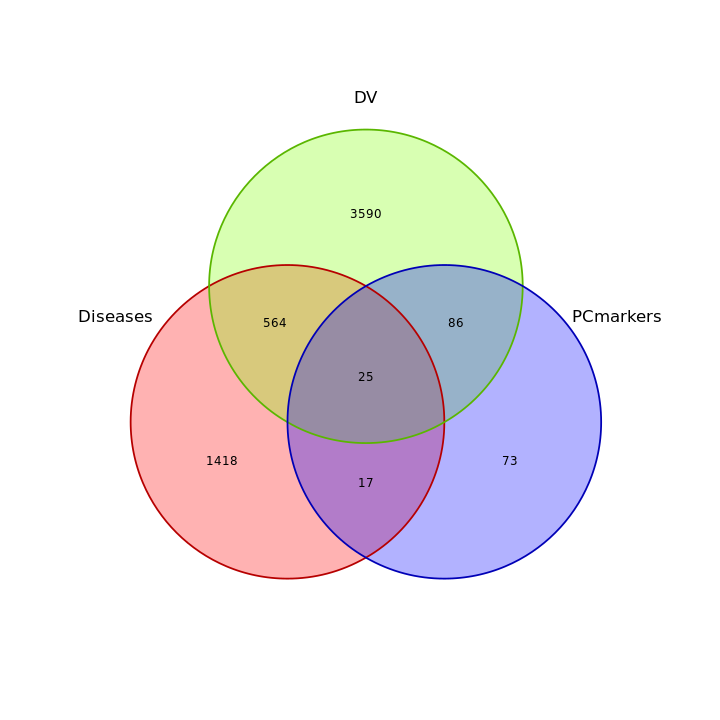

In [22]:
fig(6,6)
venn::venn(venn.df, ilabels = "counts", zcolor = 'style', box=F, ggplot=T) -> p
p

#### Subset to disease **and**/or DV biased

In [23]:
# Filter markers
# run_tag <- '.in_DV_and_Disease'
# pc.markers <- subset(pc.markers, geneHuman %in% intersect(venn.list$DV, venn.list$Diseases))
# run_tag <- '.in_Disease'
# pc.markers <- subset(pc.markers, geneHuman %in% venn.list$Diseases)
# run_tag <- '.in_DV'
# pc.markers <- subset(pc.markers, geneHuman %in% venn.list$DV)
# run_tag <- '.in_DV_or_Disease'
pc.markers <- subset(pc.markers, geneHuman %in% union(venn.list$DV, venn.list$Diseases))
run_tag <- '.no_intersections'
dim(pc.markers)
length(unique(pc.markers$geneHuman))
pc.markers

[1] 128   8

[1] 128

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,geneHuman
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,1.3666645,0.584,0.173,0.000000e+00,GE RG NKX2-1 DLK1,MEIS2,MEIS2
4.713510e-129,0.9693123,0.418,0.186,8.171812e-125,GE RG NKX2-1 DLK1,FAM181B,FAM181B
1.136861e-105,0.9401242,0.140,0.030,1.970975e-101,GE RG NKX2-1 DLK1,HOPX,HOPX
5.120328e-94,0.7826984,0.359,0.173,8.877113e-90,GE RG NKX2-1 DLK1,GNG3,GNG3
2.298225e-76,0.6694258,0.248,0.102,3.984433e-72,GE RG NKX2-1 DLK1,GAP43,GAP43
1.014015e-75,0.6474617,0.354,0.173,1.757998e-71,GE RG NKX2-1 DLK1,STMN2,STMN2
6.345716e-64,0.4915654,0.149,0.048,1.100157e-59,GE RG NKX2-1 DLK1,THSD4,THSD4
8.078482e-56,0.5809916,0.446,0.287,1.400567e-51,GE RG NKX2-1 DLK1,CADM1,CADM1
3.044122e-48,0.4638971,0.162,0.065,5.277594e-44,GE RG NKX2-1 DLK1,PSD3,PSD3


In [24]:
markers.per.cluster <- split(pc.markers$gene, pc.markers$cluster) 

In [26]:
all(unique(pc.markers$gene) %in% unique(dv.bias$gene))

[1] FALSE

In [27]:
# features <- rev(unique(pc.markers$gene))

In [28]:
features <- rev(unique((pc.markers %>% arrange(cluster, desc(pct.1)) )$geneHuman))

In [29]:
seu.markers <- seu[features,]
seu.markers <- ScaleData(seu.markers)

Centering and scaling data matrix



In [30]:
# all(pc.markers$gene%in%rownames(seu[['RNA']]@counts))
# all(pc.markers$geneHuman%in%rownames(seu[['RNA']]@counts))

pc.seu <- subset(seu.markers, subtype %in% pc.subtypes)
pc.seu <- ScaleData(pc.seu)

Centering and scaling data matrix



### DotPlot of PC markers with column of DorsoVentral bias

#### Panel of patterning center subtypes expression

In [31]:
Idents(pc.seu) <- 'subtype'
pc.dp.data <- DotPlot(pc.seu, features = features)$data
pc.dp.data <- subset(pc.dp.data, pct.exp != 0) %>% group_by(features.plot) %>% mutate(MinMax.avg.exp.scaled = scales::rescale(x = avg.exp.scaled, to=c(0,1))) %>% ungroup()

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: C21orf62”


In [32]:
(pc.dp.data%>%arrange(features.plot, desc(pct.exp)) %>% group_by(features.plot)%>%slice_head(n=1)%>%ungroup()%>%arrange(id,desc(pct.exp)))$features.plot %>% as.character %>% rev() -> features.order

In [33]:
pc.dp.data$features.plot <- factor(as.character(pc.dp.data$features.plot), features.order)

In [34]:
DV.exp <- ggplot(pc.dp.data) + 
    geom_point(aes(y=features.plot, 
                   color=MinMax.avg.exp.scaled,
                   # color=log10(avg.exp+1),
                   size=pct.exp, x=id), 
               shape=16) +
    theme_pubr(base_family='ArialMT', legend='bottom') + labs_pubr() +
    scale_color_gradient('Expression\nPatt. Centers', #'Log10(avg.exp+1)', 
                         guide = guide_colorbar(direction = 'vertical',
                                                title.position = 'top', title.hjust = 0.5),
                         breaks=c(.1,.9), labels=c('Min','Max'),
                         low="blue", high = "red") +
    scale_size_area('% expressing cells', max_size=4,
                    guide = guide_legend(title.position = 'top', label.position = 'right',
                                         ncol = 1, title.hjust = 0.5),
                    breaks = c(1, 25,50,75,100), limits=c(1,100)) +
    ylab(NULL) + xlab('Patterning centers') + 
    scale_x_discrete(position = 'top') +

   theme(axis.line = element_blank(), axis.ticks.y = element_blank(),
         panel.border = element_rect(fill='transparent',color='black'),
         plot.background = element_blank(), 
         panel.background = element_blank(), 
          panel.grid.major = element_line(color='darkgrey', linewidth=0.1),
          axis.text.x.top = element_text(angle=45, hjust=0, vjust=0),
          axis.text.y=element_blank()
         )

#### Panel of subclasses expression

In [35]:
fig(8,20)

In [36]:
Idents(seu.markers) <- 'subclass'
mac.dp.data.subclass <- DotPlot(seu.markers, features = features.order)$data
mac.dp.data.subclass <- mac.dp.data.subclass %>% group_by(features.plot) %>% mutate(MinMax.avg.exp.scaled = scales::rescale(x = avg.exp.scaled, to=c(0,1))) %>% ungroup()

In [37]:
mac.pc.markers.exp <- ggplot(mac.dp.data.subclass) + 
    geom_point(aes(y=features.plot, color=MinMax.avg.exp.scaled, size=pct.exp, x=id), 
               shape=16) +
    scale_color_gradient('Expression\nMajor classes', #'Relative avg.\nscaled expression', 
                         guide = guide_colorbar(direction = 'vertical',
                                                title.position = 'top', title.hjust = 0.5),
                         breaks=c(.1,.9), labels=c('Min','Max'),
                         low="grey", high = "tomato", limits=c(0,1)) +
    scale_size_area('% expressing\ncells', max_size=4,
                    guide = guide_none(),
                    breaks = c(1, 25,50,75,100), limits=c(1,100)) +
    scale_x_discrete(position = 'top') +
    ylab(NULL) + xlab('Cell class') + 
    theme_pubr(base_family='ArialMT', legend='bottom') + labs_pubr() +
   theme(axis.line = element_blank(), axis.ticks.y = element_blank(),
         panel.border = element_rect(fill='transparent',color='black'),
         plot.background = element_blank(), 
         panel.background = element_blank(), 
         panel.grid.major = element_line(color='darkgrey', linewidth=0.1),
         axis.text.x.top = element_text(angle=45, hjust=0, vjust=0),
         axis.text.y=element_blank()
         )

#### Panel of DV bias

In [38]:
fig(5,10)

In [39]:
pc.dp.data.bias <- merge(pc.dp.data, dv.bias[c('gene', 'DV', 'DIV', 'log2FoldChange', 'padj')], by.x='features.plot', by.y='gene', 
                         all.x=T, all.y=F)
pc.dp.data.bias[is.na(pc.dp.data.bias$DV), 'DV'] <- 'None'
pc.dp.data.bias[is.na(pc.dp.data.bias$DIV), 'DIV'] <- 'D8'

pc.bias.data <- unique(pc.dp.data.bias[c('features.plot', 'DV', 'DIV', 'log2FoldChange', 'padj')])

# subset(pc.dp.data.bias, is.na(DV)) 

In [40]:
DV.plot <- ggplot(pc.bias.data) + 
    geom_tile(aes(y=features.plot, fill=DV, x=DIV), 
              color='black') +
    scale_fill_manual('D-V bias',
                      guide = guide_legend(title.position = 'top', ncol = 1),
                      values=dv.colors,
                      na.value='grey') +
    theme_pubr(base_family='ArialMT', legend='bottom') + labs_pubr() +
    scale_x_discrete(position = 'top', expand=expansion(mult=c(0,0))) +

          
    # scale_y_discrete(position = 'right') +
    ylab(NULL)  + xlab('DV bias') + 
   theme(legend.justification = c(0, 1),
         axis.line = element_blank(), 
         panel.border = element_rect(fill='transparent',color='black'),
         plot.background = element_blank(), 
         panel.background = element_blank(), 
          axis.text.x.top = element_text(angle=45, hjust=0, vjust=0),
          axis.title.x=element_blank()) 


In [48]:
DV.plot2 <- ggplot(pc.bias.data, aes(y=features.plot, fill=log2FoldChange, x=DIV)) + 
    geom_tile(color='black') +
    scale_fill_gradient2('D-V bias',
                         guide = guide_colorbar(direction = 'vertical',
                                                title.position = 'top', title.hjust = 0.5),
                         low = dv.colors['Ventral'], mid='white', high = dv.colors['Dorsal'], na.value='grey',
                         labels=c('Ventral', 'Dorsal'), breaks=c(-5,5)) +
                         # ) +
    theme_pubr(base_family='ArialMT', legend='bottom') + labs_pubr() +
    scale_x_discrete(position = 'top', expand=expansion(mult=c(0,0))) +
    geom_text(aes(label=ifelse(padj<0.05, '·', NA)), inherit.aes = T, fontface='bold') +
          
    # scale_y_discrete(position = 'right') +
    ylab(NULL)  + xlab('DV bias') + 
   theme(legend.justification = c(0, 1),
         axis.line = element_blank(), 
         panel.border = element_rect(fill='transparent',color='black'),
         plot.background = element_blank(), 
         panel.background = element_blank(), 
          axis.text.x.top = element_text(angle=45, hjust=0, vjust=0),
          axis.title.x=element_blank()) 


Warning message:
“Removed 225 rows containing missing values (`geom_text()`).”


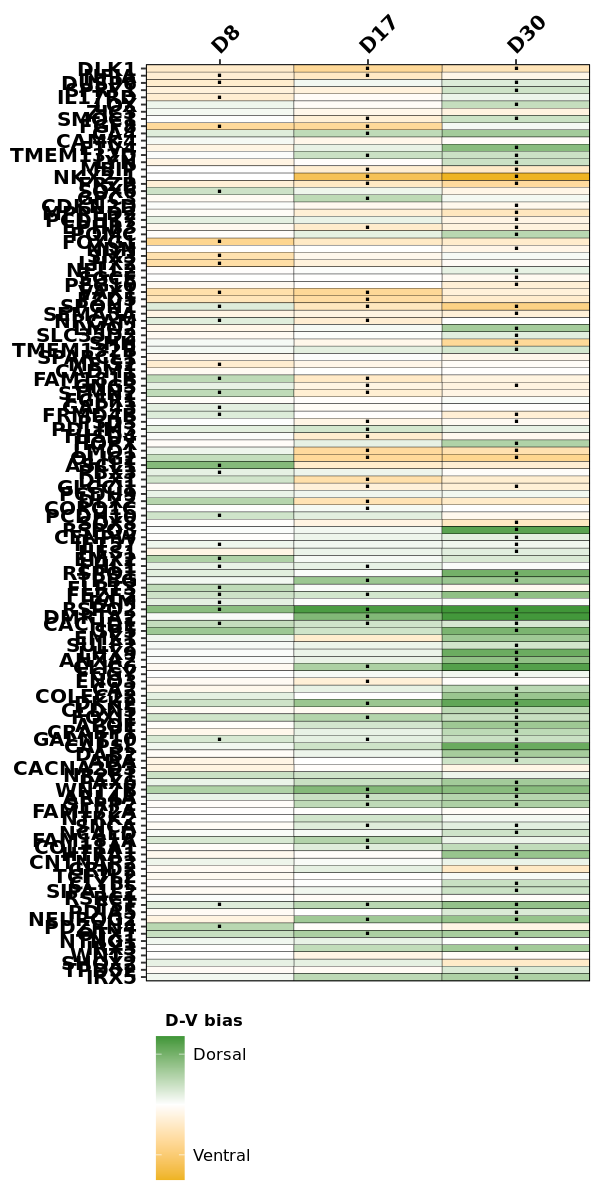

In [49]:
DV.plot2

#### Panel of Disease status

In [50]:
pc.diseases <- merge(
    unique(pc.markers[,c('gene', 'geneHuman')]),
    by.x = 'geneHuman',
    reshape2::melt(diseases.df[unique(pc.markers$geneHuman),] %>% mutate(gene=unique(pc.markers$geneHuman)),
                       id.vars='gene', variable.name='Disease', value.name='Risk'),
    by.y='gene', all=F) %>% subset(gene %in% unique(pc.dp.data.bias$features.plot))
subset(pc.diseases, Disease %in%
       subset(pc.diseases%>%group_by(Disease)%>%summarise(n=sum(Risk, na.rm = T)), n!=0)$Disease) -> pc.diseases

In [51]:
pc.dis.conf <- ggplot(data = pc.diseases,
                   aes(y=factor(gene, features.order), x=Disease, fill=as.character(Risk))) + 
    geom_tile(color='black') + 
    scale_fill_manual('Disease association', guide=guide_none(), values=c('0'='#FAFAFA', '1'='tomato'), na.value='#FAFAFA') +
    ylab(NULL) + xlab('Disease') + 
    theme_pubr(base_family='ArialMT', legend='bottom') + labs_pubr() +
    scale_x_discrete(position = 'top', expand=expansion(mult=c(0,0))) +

   theme(axis.line = element_blank(), axis.ticks.y = element_blank(),
         panel.border = element_rect(fill='transparent',color='black'),
         plot.background = element_blank(), 
         panel.background = element_blank(), 
         panel.grid.major = element_line(color='lightgrey'),
         axis.text.x.top = element_text(angle=45, hjust=0, vjust=0),
         axis.text.y=element_blank()
         )

#### Combined panels

In [52]:
# 57, 12
# 95, 16
# 295, 42
# 333, 48
model.h <- lm(formula = 'y~x', data = data.frame(x=c(57,95, 295,333), y=c(12,16, 42,48)))
length(features.order)
h <- model.h$coefficients[2]* length(features.order) +model.h$coefficients[1]
h

[1] 127

x 
20.64061

In [53]:
features.order

[1] "IRX5"     "TPD52"    "SHOX2"    "WNT3"     "IRX3"     "NTNG1"   
  [7] "OTX1"     "PDZRN4"   "NEUROG2"  "PDIA5"    "FST"      "RSRC1"   
 [13] "SIPA1L2"  "CLYBL"    "TCF7L2"   "GRID2"    "CNTNAP2"  "HTRA1"   
 [19] "COL11A1"  "FAM181A"  "NCALD"    "SNCA"     "NTRK2"    "FAM172A" 
 [25] "SFRP2"    "ARL4A"    "WNT7B"    "PAX6"     "NR2F1"    "CACNA2D3"
 [31] "ADA"      "DAB2"     "CAPSL"    "GALNT10"  "CRABP1"   "APOE"    
 [37] "FOXJ1"    "CLDN5"    "DKK2"     "COLEC12"  "CA2"      "ENO3"    
 [43] "FGGY"     "CLIC6"    "ANXA2"    "LHX9"     "SULF2"    "EMX1"    
 [49] "SP5"      "CACHD1"   "DMRTA2"   "RSPO2"    "PAM"      "FEZF2"   
 [55] "FLRT3"    "TPBG"     "RSPO1"    "FHL1"     "EMX2"     "HES1"    
 [61] "IFT57"    "CENPW"    "RSPO3"    "SOX8"     "PCDH10"   "CORO1C"  
 [67] "DLX2"     "PCDH9"    "GLCCI1"   "DLX1"     "PBX3"     "ASCL1"   
 [73] "OLIG2"    "LMO1"     "HOPX"     "THSD4"    "PDLIM3"   "PSD3"    
 [79] "FRMD4B"   "GAP43"    "FGFR1"    "STMN2"    "GNG3"     "FAM181B" 
 [85] "CADM1"    "MEIS2"    "SPARCL1"  "TMEM132B" "SHH"      "SLC35D2" 
 [91] "LMO2"     "NRCAM"    "SEMA5A"   "SPON1"    "FZD5"     "VAX1"    
 [97] "PEG10"    "SGCE"     "NELL2"    "LHX2"     "SIX3"     "NDN"     
[103] "FOXG1"    "POMC"     "EPHB3"    "PCDH17"   "MPPED2"   "CDKN2D"  
[109] "GPC3"     "SOX6"     "FRZB"     "NKX2-1"   "MBIP"     "LYN"     
[115] "TMEM132D" "ETV4"     "CAMK4"    "CA4"      "FGF8"     "SMOC1"   
[121] "ZIC3"     "LOX"      "IL17RD"   "SPRY1"    "DUSP6"    "NFIA"    
[127] "DLK1"

In [54]:
dis.pc.markers.comb <- cowplot::plot_grid(pc.dis.conf, DV.plot, DV.exp, mac.pc.markers.exp, NULL, 
                                          nrow=1, align='h', axis='tb',
                                          rel_widths = c(5,3.5,3.5,5.5,1))
dis.pc.markers.comb2 <- cowplot::plot_grid(pc.dis.conf, DV.plot2, DV.exp, mac.pc.markers.exp, NULL, 
                                          nrow=1, align='h', axis='tb',
                                          rel_widths = c(5,3.5,3.5,5.5,1))


Warning message:
“Removed 187 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 475 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 225 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 187 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 475 rows containing missing values (`geom_point()`).”


In [ ]:
# pdf('Fig3B.All_PCmark_Dis.maxpct2_5.pdf', 
#     height=12, width=12, useDingbats = F)

cairo_pdf(glue::glue(
    'Fig2B.PCmarkers{run_tag}{marker_filter}.pdf'), 
    height=h, width=12, onefile=T)
# pdf('Fig3B.All_PCmark_Dis.maxpct2_20.pdf', 
#     height=16, width=12, useDingbats = F)
plot(dis.pc.markers.comb)
plot(dis.pc.markers.comb2)
dev.off()